for Swati-san's microglia data, and practice for MicrogliaTrackingGUI development

In [3]:
import sys
import os

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class TIFStackExplorerGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "TIFSTACK_EXPLORER"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]
        self.app_key_pri = self.app_keys[0]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # layout for file load
        self.layout_file_load = QVBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # layout for main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)
        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
            self.control_manager.view_controls[self.app_key_pri].updateView()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            clearLayout(self.layout_main_ui)
        
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()

        self.setupUI_done = True

    def loadData(self):
        success = self.data_manager.loadTiffStack(
            key_app=self.app_key_pri,
            path_tiff=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_tiff"].text(),
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1)

    def setupControls(self):
        self.control_manager.view_controls[self.app_key_pri] = ViewControl(
            key_app=self.app_key_pri,
            q_view=self.widget_manager.dict_view[self.app_key_pri], 
            q_scene=self.widget_manager.dict_scene[self.app_key_pri], 
            data_manager=self.data_manager, 
            widget_manager=self.widget_manager,
            config_manager=self.config_manager,
            control_manager=self.control_manager,
        )
        self.control_manager.view_controls[self.app_key_pri].setViewSize()
        pass

    """
    makeLayout Function; Component
    return -> Layout
    """
    "Upper Left"
    def makeLayoutComponentImageView(self):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            self.app_key_pri,
            slider_z=True,
            slider_t=True,
            key_label_z=f"{self.app_key_pri}_plane_z",
            key_label_t=f"{self.app_key_pri}_plane_t",
            key_slider_z=f"{self.app_key_pri}_plane_z",
            key_slider_t=f"{self.app_key_pri}_plane_t",
            stack_size_z=self.data_manager.getSizeOfZ(self.app_key_pri),
            stack_size_t=self.data_manager.getSizeOfT(self.app_key_pri),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastSlider(self):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{self.app_key_pri}_{channel}", 
                key_checkbox=f"{self.app_key_pri}_{channel}", 
                key_slider=f"{self.app_key_pri}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))
        layout.addLayout(layout_channel)
        return layout

    "Upper Right"
    def makeLayoutComponentImageRegistration(self):
        layout = makeLayoutImageRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_key_pri,                 
            f"elastix_registration",
            f"elastix_ref_plane_t",
            f"elastix_ref_plane_z",
            f"elastix_method",
            f"elastix_ref_plane_t",       
            f"elastix_ref_plane_z",        
            f"elastix_config", 
            f"elastix_run_t",   
            f"elastix_run_z",    
        )
        return layout
    
    def makeLayoutComponentImageNormalization(self):
        layout = makeLayoutImageNormalization(
            self.widget_manager,
            key_label=f"{self.app_key_pri}_normalization",
            key_label_area=f"{self.app_key_pri}_normalization_area",
            key_lineedit_area=f"{self.app_key_pri}_normalization_area",
            key_button_area=f"{self.app_key_pri}_normalization_area_set",
            key_button_add=f"{self.app_key_pri}_normalization_area_add",
            key_button_remove=f"{self.app_key_pri}_normalization_area_remove",
            key_button_clear=f"{self.app_key_pri}_normalization_area_clear",
            key_button_run=f"{self.app_key_pri}_normalization_run",
            key_listwidget=f"{self.app_key_pri}_normalization_area",
        )
        return layout

    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()

        # LineEdit
        list_label = ["Microglia tiff image file path"]
        list_key = [f"{self.app_key_pri}_path_tiff"]
        for label, key in zip(list_label, list_key):
            layout.addLayout(makeLayoutLoadFileWidget(
                self.widget_manager, 
                label=label, 
                key_label=key, 
                key_lineedit=key, 
                key_button=key
            ))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    """
    makeLayout Function; Section

    """
    def makeLayoutSectionLeftUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView())
        layout.addLayout(self.makeLayoutComponentContrastSlider())
        return layout
    
    def makeLayoutSectionRightUpper(self):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageRegistration())
        layout.addLayout(self.makeLayoutComponentImageNormalization())
        return layout

    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    def showSubWindowElastixParamsConfig(self):
        config_window = ElastixParamsConfigDialog(
            self, 
            self.config_manager.json_config.get("elastix_params"),
            self.config_manager.gui_defaults,
        )
        if config_window.exec_() == QDialog.Accepted:
            self.config_manager.json_config.set("elastix_params", config_window.elastix_params)

    """
    bindFunc Function
    """
    def bindFuncFileLoadUI(self):        
        list_key = [f"{self.app_key_pri}_path_tiff"]
        list_filetype = [Extension.TIFF]
        for key, filetype in zip(list_key, list_filetype):
            bindFuncLoadFileWidget(
                q_widget=self, 
                q_button=self.widget_manager.dict_button[key], 
                q_lineedit=self.widget_manager.dict_lineedit[key], 
                filetype=filetype
            )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])

    def bindFuncAllWidget(self):
        self.widget_manager.dict_button[f"help"].clicked.connect(lambda: self.control_manager.view_controls[self.app_key_pri].updateView())

        # Z,T plane slider
        bindFuncPlaneZSlider(self.widget_manager.dict_slider[f"{self.app_key_pri}_plane_z"], self.control_manager.view_controls[self.app_key_pri])
        bindFuncPlaneTSlider(self.widget_manager.dict_slider[f"{self.app_key_pri}_plane_t"], self.control_manager.view_controls[self.app_key_pri])
        
        # Slider Contrast valueChanged, Checkbox show channel stateChanged
        for channel in self.config_manager.gui_defaults["CHANNELS"]:
            bindFuncBackgroundContrastSlider(
                q_slider_min=self.widget_manager.dict_slider[f"{self.app_key_pri}_{channel}_contrast_min"],
                q_slider_max=self.widget_manager.dict_slider[f"{self.app_key_pri}_{channel}_contrast_max"],
                view_control=self.control_manager.view_controls[self.app_key_pri],
                channel=channel
            )
            bindFuncBackgroundVisibilityCheckbox(
                q_checkbox=self.widget_manager.dict_checkbox[f"{self.app_key_pri}_{channel}_show"], 
                view_control=self.control_manager.view_controls[self.app_key_pri],
                channel=channel,
            )

        # set rectangle range and draw rectangle
        bindFuncButtonSetRectangeRange(
            q_widget=self,
            q_button=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_area_set"],
            q_lineedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_normalization_area"],
            view_control=self.control_manager.view_controls[self.app_key_pri]
        ) 
        # add, remove, clear rectangle range
        bindFuncButtonManageRectangleRangeForListWidget(
            q_widget=self,
            q_button_add=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_area_add"],
            q_button_remove=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_area_remove"],
            q_button_clear=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_area_clear"],
            q_listwidget=self.widget_manager.dict_listwidget[f"{self.app_key_pri}_normalization_area"],
            q_lineedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_normalization_area"],
            view_control=self.control_manager.view_controls[self.app_key_pri]
        )
        # drag and draw rectangle
        bindFuncViewMouseEventForTIFF(
            q_view=self.widget_manager.dict_view[self.app_key_pri],
            q_lineedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_normalization_area"],
            view_control=self.control_manager.view_controls[self.app_key_pri],
            table_control=None
        )
        # highlight rectangle with selected listwidget item
        bindFuncListWidgetSelectionChanged(
            q_listwidget=self.widget_manager.dict_listwidget[f"{self.app_key_pri}_normalization_area"],
            view_control=self.control_manager.view_controls[self.app_key_pri]
        )
        # run normalization
        bindFuncButtonRunImageNormalization(
            q_widget=self,
            q_button=self.widget_manager.dict_button[f"{self.app_key_pri}_normalization_run"],
            q_lineedit=self.widget_manager.dict_lineedit[f"{self.app_key_pri}_path_tiff"],
            q_listwidget=self.widget_manager.dict_listwidget[f"{self.app_key_pri}_normalization_area"],
            tiff_stack=self.data_manager.getTiffStack(self.app_key_pri),
            metadata=self.data_manager.getTiffMetadata(self.app_key_pri),
        )
        # Elastix config
        self.widget_manager.dict_button[f"elastix_config"].clicked.connect(
            lambda: self.showSubWindowElastixParamsConfig()
        )


if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = TIFStackExplorerGUI()
    gui.show()
    sys.exit(app.exec_())

SystemExit: 0

(562, 568, 2, 67, 5)


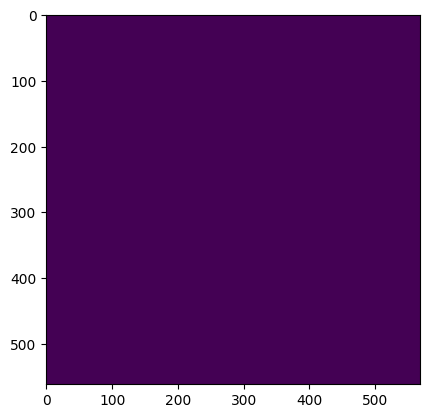

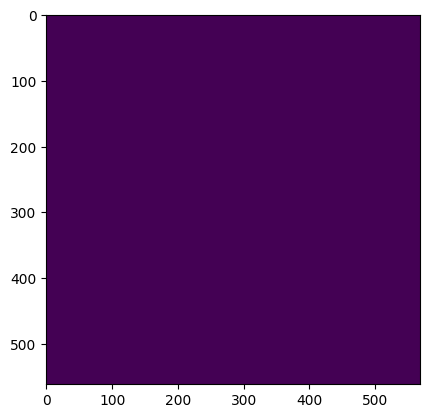

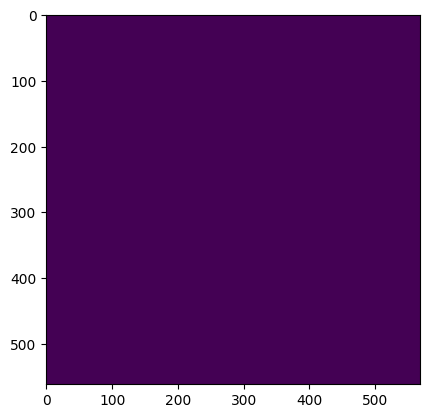

(<matplotlib.image.AxesImage at 0x2222aa32610>, None)

In [6]:
from optic.processing.elastix import runElastix
import matplotlib.pyplot as plt
import itk

tiff_stack = gui.data_manager.getTiffStack("pri")
print(tiff_stack.shape)
img_fix = tiff_stack[:, :, 1, 0, 0]
img_mov = tiff_stack[:, :, 1, 0, -1]
plt.imshow(img_fix), plt.show()
plt.imshow(img_mov), plt.show()

elastix_params = gui.config_manager.json_config.get("elastix_params")["affine"]
parameter_map = convertDictToElastixFormat(elastix_params)

parameter_object = itk.ParameterObject.New()
parameter_object.AddParameterMap(parameter_map)

# avoid "input array was not contiguous" error
img_fix = np.ascontiguousarray(img_fix)
img_mov = np.ascontiguousarray(img_mov)

img_fix = itk.image_view_from_array(img_fix)
img_mov = itk.image_view_from_array(img_mov)


img_res, result_transform_parameters = itk.elastix_registration_method(
    img_fix, 
    img_mov, 
    parameter_object=parameter_object,
    output_directory=""
    )

img_res = itk.array_from_image(img_res)
plt.imshow(img_res), plt.show()

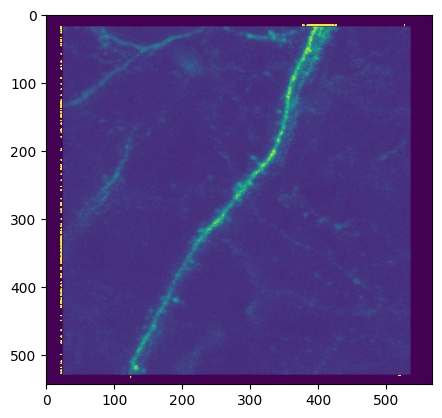

In [43]:
plt.imshow(img_res, vmin=0, vmax=3000)

In [3]:
?itk.elastix_registration_method

Signature:
itk.elastix_registration_method(
    *args,
    fixed_image: 'itk.Image' = Ellipsis,
    moving_image: 'itk.Image' = Ellipsis,
    fixed_mask: 'itk.Image' = Ellipsis,
    moving_mask: 'itk.Image' = Ellipsis,
    parameter_object=Ellipsis,
    initial_transform_parameter_file_name: str = Ellipsis,
    initial_transform_parameter_object=Ellipsis,
    initial_transform: 'itk.Transform' = Ellipsis,
    external_initial_transform: 'itk.Transform' = Ellipsis,
    fixed_point_set_file_name: str = Ellipsis,
    moving_point_set_file_name: str = Ellipsis,
    output_directory: str = Ellipsis,
    log_file_name: str = Ellipsis,
    log_to_console: bool = Ellipsis,
    log_to_file: bool = Ellipsis,
    log_level=Ellipsis,
    number_of_threads: int = Ellipsis,
    **kwargs,
) -> Union[ForwardRef('itk.ImageBase'), numpy.__array_like._SupportsArray[numpy.dtype], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes,

In [3]:
import ast

ast.literal_eval("aa")

ValueError: malformed node or string: <_ast.Name object at 0x000002E23CED48B0>